/tmp/ipython-input-1590445812.py:115: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
/tmp/ipython-input-1590445812.py:115: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
/tmp/ipython-input-1590445812.py:115: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
/tmp/ipython-input-1590445812.py:116: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.savefig("sales_dashboard.png")
/tmp/ipython-input-1590445812.py:116: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans.
  plt.savefig("sales_dashboard.png")
/tmp/ipython-input-1590445812.py:116: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig("sales_dashboard.png")


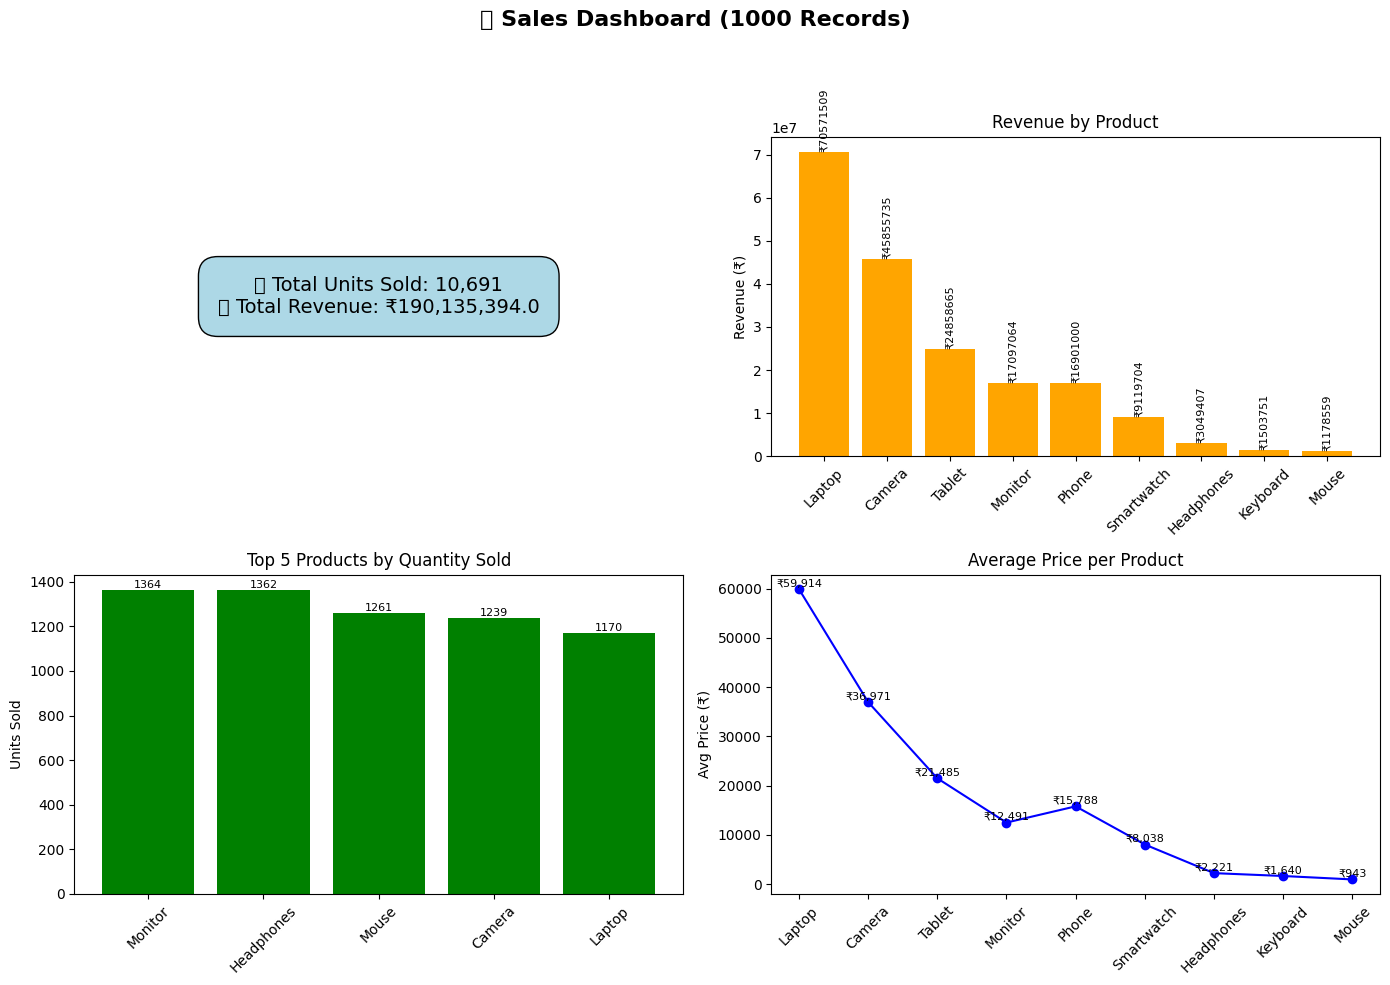

In [4]:
# ✅ Required imports
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import random

%matplotlib inline

# -------------------------------
# Step 1: Create SQLite Database & Table
# -------------------------------
conn = sqlite3.connect("sales_data.db")
cursor = conn.cursor()
cursor.execute("DROP TABLE IF EXISTS sales")

cursor.execute("""
CREATE TABLE sales (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    product TEXT,
    quantity INTEGER,
    price REAL
)
""")

# Product catalog with price ranges
products = {
    "Laptop": (50000, 70000),
    "Phone": (12000, 20000),
    "Tablet": (18000, 25000),
    "Headphones": (1500, 3000),
    "Smartwatch": (6000, 10000),
    "Camera": (30000, 45000),
    "Monitor": (10000, 15000),
    "Keyboard": (1200, 2000),
    "Mouse": (700, 1200)
}

# -------------------------------
# Step 2: Generate 1000 random sales rows
# -------------------------------
sample_data = []
for _ in range(1000):
    product = random.choice(list(products.keys()))
    min_price, max_price = products[product]
    price = random.randint(min_price, max_price)
    quantity = random.randint(1, 20)
    sample_data.append((product, quantity, price))

cursor.executemany("INSERT INTO sales (product, quantity, price) VALUES (?, ?, ?)", sample_data)
conn.commit()

# -------------------------------
# Step 3: SQL Queries
# -------------------------------
query_summary = """
SELECT product,
       SUM(quantity) AS total_qty,
       SUM(quantity * price) AS revenue,
       ROUND(AVG(price), 2) AS avg_price
FROM sales
GROUP BY product
ORDER BY revenue DESC
"""
df = pd.read_sql_query(query_summary, conn)

query_totals = """
SELECT SUM(quantity) AS total_units,
       SUM(quantity * price) AS total_revenue
FROM sales
"""
totals = pd.read_sql_query(query_totals, conn)

# -------------------------------
# Step 4: Dashboard Layout
# -------------------------------
fig = plt.figure(figsize=(14,10))
fig.suptitle("📊 Sales Dashboard (1000 Records)", fontsize=16, fontweight="bold")

# --- Top Summary Box ---
ax0 = fig.add_subplot(2,2,1)
ax0.axis("off")
summary_text = (
    f"✅ Total Units Sold: {totals['total_units'][0]:,}\n"
    f"💰 Total Revenue: ₹{totals['total_revenue'][0]:,}"
)
ax0.text(0.5, 0.5, summary_text, fontsize=14, ha="center", va="center",
         bbox=dict(boxstyle="round,pad=1", facecolor="lightblue"))

# --- Chart 1: Revenue by Product ---
ax1 = fig.add_subplot(2,2,2)
bars1 = ax1.bar(df["product"], df["revenue"], color="orange")
ax1.set_title("Revenue by Product")
ax1.set_ylabel("Revenue (₹)")
ax1.tick_params(axis="x", rotation=45)
ax1.bar_label(bars1, fmt="₹%d", fontsize=8, rotation=90, label_type="edge")

# --- Chart 2: Top 5 by Quantity ---
ax2 = fig.add_subplot(2,2,3)
top_qty = df.sort_values(by="total_qty", ascending=False).head(5)
bars2 = ax2.bar(top_qty["product"], top_qty["total_qty"], color="green")
ax2.set_title("Top 5 Products by Quantity Sold")
ax2.set_ylabel("Units Sold")
ax2.tick_params(axis="x", rotation=45)
ax2.bar_label(bars2, fontsize=8, label_type="edge")

# --- Chart 3: Average Price per Product (Line Chart) ---
ax3 = fig.add_subplot(2,2,4)
ax3.plot(df["product"], df["avg_price"], marker="o", linestyle="-", color="blue")
ax3.set_title("Average Price per Product")
ax3.set_ylabel("Avg Price (₹)")
ax3.tick_params(axis="x", rotation=45)
for i, val in enumerate(df["avg_price"]):
    ax3.text(i, val+500, f"₹{val:,.0f}", ha="center", fontsize=8)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("sales_dashboard.png")
plt.show()

# Close connection
conn.close()
